# Glasserman-style news regressions and topic persistence

This notebook takes the fixed LDA topic model trained on CC-NEWS articles and links
its firm-level topic exposure vectors to equity returns in a **Glasserman-style**
framework. Conceptually we follow Glasserman–Krstovski–Laliberte–Mamaysky:
topics are estimated once, exposure vectors are aggregated to the firm–period level,
and regressions map lagged exposures and firm characteristics into intraday and
overnight returns.

Relative to the original paper, we make four deliberate changes:

1. **Different sample and rolling window.**  
   4 different LDA models are trained once on CC-NEWS from 2016–2022 and then
   used for inference on 2022–2025 to create a fully OOS time period.
   Return regressions use a shorter equity sample than the original paper, so we work with **one-year
   exposure windows** ($n = 1$) rather than four-year windows. With $n = 1$ the
   "rolling window" becomes a single lag, which makes the panel explicitly
   dynamic and preserves effective sample length.

2. **Elastic Net instead of pure lasso.**  
   Glasserman uses lasso to select a sparse set of predictive topics. Here we use
   an **Elastic Net (EN) penalty** with mixing parameter $\alpha_{\text{EN}}$
   close to one:
   - the $\ell_1$ component keeps the number of active topics manageable, and  
   - the small $\ell_2$ component stabilizes coefficients when topics are highly
     collinear.

3. **Dynamic panels with GMM and explicit selection correction.**  
   Both the topic persistence regressions and the return regressions include
   **lagged dependent variables** with unobserved firm, topic and/or time
   heterogeneity. In Wooldridge’s language (Chapter 11), this puts us in the
   world of **unobserved effects models under sequential moment restrictions**
   rather than strict exogeneity. At the same time, our panel is **unbalanced**:
   firms enter and exit the S&P 500 and, even for a given firm–topic pair,
   some years have no relevant articles at all. Because the appearance of a
   firm–topic cell in the panel is unlikely to be mean independent of the
   idiosyncratic error, we do not treat missing cells as innocuous. Instead we
   - model the observation indicator with a **first-stage probit selection
     equation**, and
   - feed the resulting **inverse Mills ratio** into the outcome equation as a
     control function.  
   We then estimate the augmented dynamic-panel outcome by **Arellano–Bond–style
   GMM**, using lags of the dependent variable as instruments and treating the
   selection-correction term as an additional (predetermined) regressor. Fixed
   effects serve as a benchmark, but our main estimates are GMM-with-selection.

4. **State-space smoothing of forecast coefficients.**  
   With annual data we are in a **large-$N$, small-$T$** setting, so the year-by-year
   EN–GMM estimates $\hat{\boldsymbol{\beta}}_t$ can be noisy. To hedge against this
   small-$T$ instability, we place the coefficient vectors in a simple **state-space
   model** (e.g. an AR(1) evolution for $\boldsymbol{\beta}_t$) and apply
   **Kalman smoothing**. This produces smoothed paths
   $\tilde{\boldsymbol{\beta}}_t$ that borrow strength across adjacent years. We then
   base portfolio construction on the smoothed $\tilde{\boldsymbol{\beta}}_t$, with the
   explicit goal of reducing forecast noise and **alleviating excessive turnover** while
   still allowing for gradual structural change in the news–return relationship.

The rest of the notebook is organised as follows:

1. **Topic persistence.** Define firm–period topic exposure vectors and estimate
   dynamic panel regressions of $t+1$ exposures on lagged exposures, using
   GMM plus a Heckman-style selection correction to handle lagged dependent
   variables and non-random observation of firm–topic–year cells.
2. **Annual returns and characteristics.** Build firm-year panels of intraday and
   overnight returns plus standard characteristics (size, value, momentum,
   etc.).
3. **Elastic-Net GMM return regressions.** Run Glasserman-style regressions of
   annual intraday/overnight returns on lagged topic exposures and controls,
   estimated by EN plus GMM (again with a selection correction),
   and compare to FE benchmarks.
4. **Forecasts and portfolio inputs.** Store fitted return forecasts in
   `return_forecasts` for use in the backtesting and portfolio-construction
   notebooks.

---

## 1. Topic persistence in firm-level news exposures

The first step is to verify that **firm-level topic exposures are persistent over time**.
If a firm’s news loads heavily on topic $k$ in year $t$, we want to confirm that it tends
to keep loading on the same topic in year $t+1$, separately for intraday and overnight
news.

### 1.1 overview

#### 1.1.1 Document-level topic probabilities

Fix a single LDA run and let $k \in \{1,\dots,K\}$ index topics and $a$ index news
articles.

For each article $a$, MALLET produces a document–topic probability vector
$\boldsymbol{\theta}^a \in \mathbb{R}^K$ with
$\theta^a_k$ interpreted as the exposure of article $a$ to topic $k$:

\begin{equation}
\boldsymbol{\theta}^a
=
(\theta^a_1,\dots,\theta^a_K),
\quad
\sum_{k=1}^K \theta^a_k = 1
\end{equation}

These $\theta^a_k$ are the basic building blocks for firm-level topic exposures.

#### 1.1.2 Firm-period exposure vectors

Let $j$ index firms and let $s \in \{i,o\}$ denote the session:
$s = i$ for intraday news and $s = o$ for overnight news.

For a given firm $j$, period $t$, and session $s$, define the set of relevant
articles:

\begin{equation}
A^{s}_{j,t}
=
\{\text{articles } a \text{ in period } t \text{ that mention firm } j
\text{ in session } s\}
\end{equation}

The **firm-level exposure of company $j$ to topic $k$ in period $t$ and session $s$**
is then:

\begin{equation}
z^{s}_{j,k,t}
=
\sum_{a \in A^{s}_{j,t}} \theta^a_k
\end{equation}

When $t$ is a trading day, $z^{s}_{j,k,t}$ is the total exposure of firm $j$
to topic $k$ in that day and session. When $t$ is a calendar year, the same
definition applied to all trading days in the year yields **annual** exposures.

We also define an "all new" version that aggregates intraday and overnight
exposures:

\begin{equation}
z^{\mathrm{all}}_{j,k,t}
=
z^{i}_{j,k,t} + z^{o}_{j,k,t}
\end{equation}

For each firm–year $(j,t)$ we therefore have three $K$-dimensional exposure
vectors
$\{z^{i}_{j,\cdot,t}, z^{o}_{j,\cdot,t}, z^{\mathrm{all}}_{j,\cdot,t}\}$.

In what follows we work at the **yearly** level for persistence: $t$ indexes
calendar years, and all $z^{s}_{j,k,t}$ are constructed from full-year news.

#### 1.1.3 One-year "window" and dynamic structure

Glasserman’s persistence regressions use **multi-year averages** of past
exposures. For a generic window length $n \ge 1$, define:

\begin{equation}
\bar{z}^{s}_{j,k,t+1;n}
=
\frac{1}{n}
\sum_{r = 0}^{n-1} z^{s}_{j,k,t-r}
\end{equation}

Their baseline specification uses $n = 4$. In this project we set:

\begin{equation}
n = 1,
\end{equation}

to conserve effective sample length. With $n = 1$ the rolling average collapses to:

\begin{equation}
\bar{z}^{s}_{j,k,t;1} = z^{s}_{j,k,t}
\end{equation}

so the persistence regressions become **dynamic panels with a single lag** rather
than moving averages of past exposures. It is important to stress that with
$n = 1$ we are *not* smoothing over multiple years: we genuinely use the
previous year’s exposure as a regressor.

#### 1.1.4 Dynamic-panel specification, attrition, and selection

For each session $s \in \{i,o,\mathrm{all}\}$ we would like to estimate the persistence
regression:

\begin{equation}
z^{s}_{j,k,t+1}
=
\alpha_j
+
\alpha_k
+
\rho^{s} z^{s}_{j,k,t}
+
u^{s}_{j,k,t+1}
\end{equation}

where:

- $\alpha_j$ is a firm fixed effect,
- $\alpha_k$ is a topic fixed effect,
- $\rho^{s}$ is the **persistence parameter** for session $s$, and
- $u^{s}_{j,k,t+1}$ is an idiosyncratic error.

This is Wooldridge’s dynamic unobserved-effects model (Chapter 11) with
$y_{it} = z^{s}_{j,k,t}$ and $c_i = \alpha_j + \alpha_k$. The panel is **unbalanced**:
firms enter and exit the S&P 500 and, for a given $(j,k)$, some years have no
relevant news at all. Define the observation indicator:

\begin{equation}
I^{s}_{j,k,t}
=
\mathbf{1}\{z^{s}_{j,k,t} \text{ is observed}\}
\end{equation}

so that the outcome equation is only observed when $I^{s}_{j,k,t} = 1$ and
$I^{s}_{j,k,t+1} = 1$. We do not want to assume that this "attrition" is mean
independent of $u^{s}_{j,k,t+1}$. Instead we model it explicitly via a selection
equation.

#### 1.1.5 Selection equation and inverse Mills ratio

Let $w_{j,k,t}^s$ collect variables that are plausibly important for whether we observe a valid data point for firm $j$ and topic $k$ in year $t$ and session $s$.

Crucially, our observation process is a **composite selection mechanism**:
1.  **Index Survival:** The firm must be in the S&P 500. This is our **base universe**.
2.  **News Existence:** The firm must generate news articles with non-zero exposure to topic $k$. This is the **conditional outcome**.

To account for both, we model the probability of *news observation conditional on index membership*. We include the following variables in the selection equation:
* A lagged selection indicator $I_{j,k,t-1}^s$ (topic stickiness), capturing the persistence of specific news themes.
* A firm-level news intensity estimator $\hat{\lambda}_{j,t-1}^s$, capturing the general propensity of the firm to generate news.
* **Lagged Log Market Capitalization** $\ln(\text{MarketCap}_{j,t-1})$. Since size is the primary determinant of S&P 500 inclusion, this control effectively proxies for the "Index Survival" probability, correcting for the bias arising from firms dropping out of the sample.

We then estimate, for each session $s$, the probit selection equation:

$$
\mathbb{P}(I_{j,k,t}^s = 1 | w_{j,k,t}^s) = \Phi(\gamma_s^{\top} w_{j,k,t}^s)
$$

where $\Phi$ is the standard normal cdf and $\gamma$ is estimated by maximum likelihood. The "zeros" in this model ($I=0$) are firms that were in the S&P 500 but had no significant news coverage on topic $k$.

#### 1.1.6 GMM estimation and choice of instruments

We still have a dynamic-panel problem: $z^{s}_{j,k,t}$ appears on the right-hand
side, so fixed effects alone would suffer from Nickell bias. Following
Wooldridge’s discussion of Arellano–Bond estimators, we work with the
first-differenced equation:

\begin{equation}
\Delta z^{s}_{j,k,t+1}
=
\rho^{s} \Delta z^{s}_{j,k,t}
+
\delta^{s} \Delta \hat m^{s}_{j,k,t}
+
\Delta \varepsilon^{s}_{j,k,t+1},
\quad t = 2,\dots,T-1
\end{equation}

Under sequential exogeneity of the shocks this yields moment conditions of the form:

\begin{equation}
E\!\left(z^{s}_{j,k,t-\ell} \, \Delta \varepsilon^{s}_{j,k,t+1}\right) = 0,
\quad \ell \ge 2
\end{equation}

so earlier lags of $z^{s}_{j,k, t - l}, \ l > 0$ serve as **internal instruments** for
$\Delta z^{s}_{j,k,t}$. The selection-correction term $\hat m^{s}_{j,k,t}$ is
constructed from lagged data and the first-stage probit, so we treat
$\Delta \hat m^{s}_{j,k,t}$ as predetermined/strictly exogenous in the GMM step.

In practice we:

- build the **difference-GMM instrument matrix** using a limited set of lags
  of $z^{s}_{j,k,t - l}$ to avoid weak instruments and "too many instruments"
  issues when $T$ is small;
- include $\Delta \hat m^{s}_{j,k,t}$ directly as a regressor in the
  differenced equation; and
- use standard diagnostics (Hansen $J$-test, tests for serial correlation in
  $\Delta \hat\varepsilon^{s}_{j,k,t}$) to assess instrument validity.

The resulting estimator is our main topic-persistence estimator. We keep the
within-FE estimates (with and without the selection term) as benchmarks:

- If GMM and FE agree, Nickell bias and selection effects are small in practice.  
- If they differ, we rely on the GMM-with-selection estimates, subject to the
  diagnostics above.

The remainder of this section constructs the annual exposure vectors
$z^{s}_{j,k,t}$, estimates the FE and GMM versions of the persistence regression
with the selection correction for $s \in \{i,o,\mathrm{all}\}$, and compares the
resulting $\hat{\rho}^{s}$’s to the values reported by Glasserman.

> **Sample restriction.** Throughout this notebook we restrict attention to
> firm–year cells in which the firm is an S&P 500 constituent. For notational
> brevity we suppress this conditioning event and write the regressions as if
> they were estimated on the full universe.

---

In [1]:
from dotenv import load_dotenv
import pandas as pd
from notebooks_utils.modeling_notebooks_utils.regression_utils.regression_utils import (
    extract_topic_persistence_selection_data, compute_firm_year_intensity
)
load_dotenv()
article_duration_df: pd.DataFrame = extract_topic_persistence_selection_data()

### 1.2 Selection estimation

#### 1.2.1 ACD-based news intensity

To construct a firm–year–session news–intensity estimator we model the **inter-arrival
durations** between news days for each firm with an exponential ACD(1,1) process
(EACD(1,1)).

For firm $j$, session $s \in \{\text{intraday}, \text{overnight}\}$ and duration
series $\{\tau_t\}_{t=1}^T$ (trading days between consecutive news days), the
EACD(1,1) model specifies the **conditional mean duration**
$\psi_t = \mathbb{E}[\tau_t \mid \mathcal{F}_{t-1}]$ as

\begin{equation}
\psi_t
  = \omega + \alpha \tau_{t-1} + \beta \psi_{t-1},
\qquad
\omega > 0,\ \alpha,\beta \ge 0,\ \alpha + \beta < 1
\end{equation}

Durations are modeled as

\begin{equation}
\tau_t = \psi_t \cdot \varepsilon_t,
\qquad
\varepsilon_t \mid \mathcal{F}_{t-1} \sim \mathrm{Exp}(1)
\end{equation}

By the change-of-variables theorem<sup>1</sup>, conditional on $\mathcal{F}_{t-1}$ we have  
$\tau_t \sim \mathrm{Exp}(1 / \psi_t)$ with density

\begin{equation}
f_{\tau_t \mid \mathcal{F}_{t-1}}(x)
  = \frac{1}{\psi_t} \exp\!\left(-\frac{x}{\psi_t}\right),
\qquad x > 0
\end{equation}

so the **conditional news arrival intensity** is

\begin{equation}
\lambda_t = \frac{1}{\psi_t}
\end{equation}

We estimate $(\omega,\alpha,\beta)$ by (quasi) maximum likelihood separately for
each firm–session. The ACD recursion captures key features of the news flow:

- **Clustering / persistence** – bursts of intense news flow followed by quieter
  periods, via the feedback terms in $\alpha$ and $\beta$.
- **Firm heterogeneity** – each firm–session obtains its own
  $(\omega,\alpha,\beta)$, so high-visibility names can have structurally higher
  news intensity than thinly covered ones.

Given fitted parameters $(\hat\omega,\hat\alpha,\hat\beta)$ we recover the
fitted conditional mean durations $\hat\psi_t$ and define the **instantaneous
news intensity** as

\begin{equation}
\hat\lambda_t = \frac{1}{\hat\psi_t}
\end{equation}

For the selection equation we aggregate this to a **firm–year–session intensity
proxy** by averaging over all events in year $y$ and session $s$:

\begin{equation}
\hat\lambda^s_{j,y}
  = \frac{1}{T^s_{j,y}} \sum_{t \in \mathcal{T}^s_{j, y}} \hat\lambda^s_{j,t}
\end{equation}

where $\mathcal{T}^s_{j, y}$ is the set of news events for firm $j$, session $s$,
in calendar year $y$, and $T^s_{j, y}$ is the number of trading days in that
firm–year–session.

**Handling Low-Information Firms ("Phantom Firms"):**
A subset of S&P 500 firms may generate zero or very few news articles in a given year. For these firms, the inter-arrival times are undefined or too sparse to estimate an ACD model.
* For these observations, we impute a **zero intensity** ($\hat{\lambda}_{j,y}^s = 0$).
* Crucially, these firms are **retained** in the selection dataset. They serve as the necessary "zeros" for the first-stage Probit, allowing us to model the extensive margin of news coverage (the probability of going from "quiet" to "noisy").

#### 1.2.2 Practical estimation and identification strategy

In practice, the ACD parameters are only identified when a firm–session has a sufficient number of observed durations. Standard Maximum Likelihood estimates for duration models can suffer from finite-sample bias and convergence failure on sparse data (Hwang and Valls Pereira, 2006).

To address this, we implement a **Tiered Identification Strategy** augmented by robust numerical safeguards.

**A. Numerical Stability "Knobs"**
To ensure convergence on sparse financial data, we employ several safeguards within the `rust_timeseries` optimization core:
1.  **Data Normalization:** Durations are pre-normalized by their unconditional mean ($\tau'_t = \tau_t / \bar{\tau}$). This ensures the optimizer operates on $O(1)$ scales, preventing boundary crashes for firms with very long mean durations.
2.  **Smart Initialization:** Recursions are initialized using the sample mean (`init="sample_mean"`), placing starting parameters in a high-probability region of the likelihood surface.
3.  **Robust Optimization:** We utilize the **Hager-Zhang** line search (which handles flat likelihood surfaces better than standard methods) and increase the L-BFGS memory history to 50 steps to better approximate curvature on difficult ridges.

**B. The Tiered Estimation Rule**
We adapt the asymptotic recommendations of Hwang and Pereira (2006) to the finite reality of news data, prioritizing sample representativeness while mitigating bias:

1.  **Tier 1: Full Dynamics (EACD 1,1) for $N \ge 200$.**
    For firm–sessions with at least 200 news events (approximating one trading year of activity), we fit the full EACD(1,1) model ($p=1, q=1$).
    * This captures both short-term clustering ($\alpha$) and long-term persistence ($\beta$).
    * **Justification:** While theoretical convergence requires larger samples, N=200 approximates the standard one-year lookback window (N=252) used in realized volatility estimation. Setting the threshold slightly below 252 allows for minor data gaps (e.g., holidays, quiet weeks) without excluding firms that effectively exhibit year-round activity.

2.  **Tier 2: Restricted Dynamics (EACD 1,0) for $50 \le N < 200$.**
    For moderately active firms, we fit a parsimonious **EACD(1,0)** model ($p=1, q=0$).
    * This corresponds to an **ARCH(1)** structure, capturing volatility clustering via lagged durations but omitting the infinite memory term.
    * **Justification:** In medium samples, estimating the persistence parameter $\beta$ is the primary source of error. By restricting $\beta=0$, we reduce estimation variance. We accept minor finite-sample bias to avoid imputing a static zero, which would introduce measurement error for these active firms.

3.  **Tier 3: Static Intensity (Low Information) for $N < 50$.**
    For firm–sessions with fewer than 50 events (including "Phantom Firms"), we assign a static intensity of zero ($\hat{\lambda}=0$).
    * **Justification:** Below this threshold, the likelihood surface is too flat to reliably distinguish dynamic clustering from noise. These firms are retained in the panel to correct for the extensive margin (existence of news) but do not contribute dynamic intensity variance.

***

<sup>1</sup> Since $\tau_t = g(\varepsilon_t)$ where $g(x) = \psi_t \cdot x$ and
$\psi_t$ is constant given $\mathcal{F}_{t-1}$, the conditional distribution of
$\tau_t$ follows from the standard change-of-variables result; see
Casella & Berger, Theorem 2.1.5.

Total firms in universe: 648
Firms with Dynamic ACD Model (Tier 1/2): 421
Firms with Static Zero Intensity (Tier 3): 227

Article-day counts by Model Type:

                   count        mean         std   min    25%    50%    75%  \
has_dynamic_model                                                             
False              227.0   18.973568   24.631069   0.0    0.0    5.0   33.0   
True               421.0  340.755344  268.328831  62.0  164.0  249.0  426.0   

                      max  
has_dynamic_model          
False                94.0  
True               1613.0  


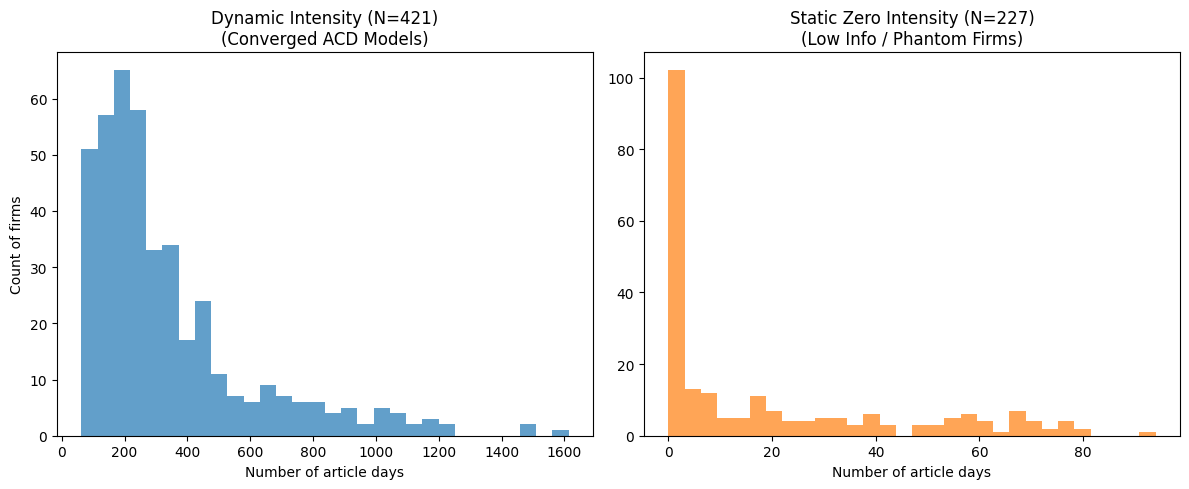

In [2]:
from notebooks_utils.modeling_notebooks_utils.regression_utils.regression_plotting import summarize_dropped_firms
intensity_df: pd.DataFrame = compute_firm_year_intensity(article_duration_df)
summarize_dropped_firms(article_duration_df, intensity_df)

#### 1.2.3 Selection equation and probit specification

Having constructed the news-intensity estimator, we formally specify the selection vector. Let $I_{j,k,y}^s$ be an indicator that firm $j$ and topic $k$ appear in the outcome panel in year $y$.

The selection covariates vector $w_{j,k,y-1}^s$ is defined as:

$$
w_{j,k,y-1}^s = \begin{pmatrix} 1 \\ I_{j,k,y-1}^s \\ \lambda_{j,y-1}^s \\ \ln(\text{MarketCap}_{j,y-1}) \end{pmatrix}
$$

where:
* $I_{j,k,y-1}^s$ is the lagged selection indicator (topic "stickiness").
* $\lambda_{j,y-1}^s$ is the lagged firm-year-session news intensity from the ACD model.
* $\ln(\text{MarketCap}_{j,y-1})$ is the lagged natural log of firm market capitalization, sourced from our equity panel (`equity_regression_panel`).

We use a standard probit specification with a latent selection index:

$$
J_{j,k,y}^s = \gamma_s^{\prime} w_{j,k,y-1}^s + v_{j,k,y}^s, \quad v_{j,k,y}^s \sim \mathcal{N}(0,1)
$$

$$
I_{j,k,y}^s = \mathbb{1}\{ J_{j,k,y}^s > 0 \}
$$

By including Market Cap, we explicitly model the "Index Survival" constraint. A firm with low market cap in $y-1$ has a higher probability of dropping out of the S&P 500 (and thus our dataset) in year $y$, regardless of its news intensity. The probit allows these two forces—news generation and index survival—to jointly determine observability.

#### 1.2.4 Inverse Mills ratio and selection correction

Under the usual Heckman-style assumptions (joint normality of the
selection error $v^s_{j,k,y}$ and the outcome error, and mean independence
of $u^s_{j,k,y}$ given $w^s_{j,k,y-1}$), the selection bias can be summarised
by an inverse Mills ratio term.

For observed cells with $I^s_{j,k,y} = 1$ we form
\begin{equation}
\hat m^s_{j,k,y}
  = \frac{\varphi\!\left(\hat\gamma_s^\top w^s_{j,k,y-1} \right)}
         {\Phi\!\left (\hat\gamma_s^\top w^s_{j,k,y-1} \right)},
\end{equation}
where $\varphi(\cdot)$ is the standard normal PDF. Intuitively,
$\hat m^s_{j,k,y}$ measures how “surprising” it is that the cell remains
selected, given its lagged inclusion status and lagged news intensity.

In the second-stage topic-persistence regression we will include
$\hat m^s_{j,k,y}$ as an additional regressor. Under the Heckman
framework, this removes the component of the outcome error that is
correlated with the selection process.

#### 1.2.5 Sample Attrition and Exogeneity Assumptions

To ensure data quality, we filter the raw universe of S&P 500 firms. We distinguish between attrition mechanisms that are plausibly orthogonal to the news-return process (safe to drop) and those that are endogenous (required for the selection correction).

**1. Exogenous Attrition (Listwise Deletion)**
We exclude specific observations where data quality compromises the entity resolution or return calculation. We contend that these exclusion criteria satisfy the condition of mean independence with respect to the outcome error term:

* **Entity Resolution Ambiguity:** Firms with names acting as common nouns (e.g., "Target", "News Corp", "Best Buy") are excluded if they generate excessive false positives in the news collection pipeline. We assume the linguistic properties of a firm's name are orthogonal to its fundamental news-return dynamics.
* **Vendor Data Gaps:** Firm-days with missing pricing data from the vendor (EODHD) are excluded. Given that we condition on S&P 500 constituency (active, solvent firms), we assume these sporadic gaps represent random technical ingestion errors rather than informative signals of financial distress (e.g., trading halts).

**2. Endogenous Attrition (Imputation and Modeling)**
Attrition mechanisms plausibly correlated with firm fundamentals are handled explicitly to avoid selection bias:

* **Missing Market Capitalization:** Occasional gaps in the market capitalization record (e.g., due to vendor feed interruptions) are **not** dropped, as listwise deletion here could correlate with corporate actions or volatility. We impute these values via forward-filling (carrying forward the last known market cap), relying on the high persistence of firm size.
* **Zero-News Firms ("The Zeros"):** Firm-years with zero identified news articles are **retained** in the first-stage probit estimation. These observations constitute the $I^s_{j,k,t}=0$ category. Excluding them would truncate the dependent variable of the selection equation, rendering the Heckman correction impossible. These firms are only excluded from the second-stage (persistence) regression *after* their contribution to the Inverse Mills Ratio has been calculated.

**3. Universe Conditioning**
Throughout, we restrict attention to the S&P 500 universe. The selection process is therefore defined as the joint probability of S&P 500 inclusion (proxied by Market Cap) and news existence (proxied by News Intensity).


In [3]:
from notebooks_utils.modeling_notebooks_utils.regression_utils.regression_utils import build_topic_selection_panel

features_df: pd.DataFrame = build_topic_selection_panel(intensity_df)

OperationalError: (psycopg2.OperationalError) server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

[SQL: 
    SELECT
        u_cik.cik,
        pna.session,
        CAST(EXTRACT(YEAR FROM pna.trading_day) AS INTEGER) as year,
        late.topic_id,
        1 AS topic_exists
    FROM lda_documents ld
    JOIN parsed_news_articles pna 
        ON ld.article_id = pna.article_id
    CROSS JOIN LATERAL unnest(pna.cik_list) AS u_cik(cik)
    JOIN lda_article_topic_exposure late 
        ON ld.article_id = late.article_id
    WHERE ld.corpus_version = 1
      AND ld.included_in_training = TRUE
      AND late.topic_exposure > 0
    GROUP BY 
        u_cik.cik, 
        pna.session, 
        CAST(EXTRACT(YEAR FROM pna.trading_day) AS INTEGER), 
        late.topic_id
    ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)